In [1]:
import os
import subprocess
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import varia
from optimisation import optimise
from simulations import simulation

from mrtrix_io.io import load_mrtrix, save_mrtrix
from mrtrix_io.io.image import Image

import utils.SphericalHarmonics as sh

In [2]:
# Add the MRtrix3 binary directory to the PATH
mrtrix_bin_dir = '/SOFTWARE/mrtrix3/bin'  # Replace with the actual path to MRtrix3 binaries
os.environ['PATH'] += os.pathsep + mrtrix_bin_dir

# Constants

In [3]:
lmax = 8

grad = varia.create_gradient_table([0, 1000, 2000], [2, 128, 128])
bvals = np.unique(np.round(grad[...,-1], -2))

Q = optimise.get_transformation_matrix(300, lmax)

varia.pretty_print_gradient_table(grad)

# Multiprocessing reduces the time to run the simulations
cores = 10

dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 1.4142135623730949
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.722616459032
dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 15221.722616470808
dirgen: [ .  ] Optimising directions up to power 1 (10 restarts)...

b-value   |   count   
----------------------
    0     |   2
 1000     |   128
 2000     |   128


dirgen: [done] Optimising directions up to power 1 (10 restarts)
dirgen: final energy = 85867.220658467602


In [4]:
# LoRE-SD Parameters
reg = 1e-3

axial_diffusivities = np.linspace(0, 4e-3, 10)
radial_diffusivities = np.linspace(0, 4e-3, 10)

gaussians = optimise.get_gaussians(axial_diffusivities, radial_diffusivities, bvals, lmax)

In [5]:
def add_noise(noise_free, grad, snr):
    """
    Add Gaussian noise or Rician noise to a signal.

    Returns:
        numpy.ndarray: A signal with added Gaussian/Rician noise.
    """

    mean_b0 = np.mean(noise_free[..., np.where(grad[...,-1] == 0)[0]])

    std_noise = mean_b0 / snr
    noise1 = np.random.normal(0, std_noise, size=noise_free.shape)
    noise2 = np.random.normal(0, std_noise, size=noise_free.shape)
    noisy_dwi = np.sqrt((noise_free + noise1)**2 + noise2**2)

    return noisy_dwi

In [6]:
def get_msmt_csd_odf(voxel_dwi, response_function, grad):
    """
    Estimate the ODF using the MSMT-CSD algorithm.

    Args:
        voxel_dwi (numpy.ndarray): The DWI data for the voxel.
        response_function (numpy.ndarray): The response function.
        grad (numpy.ndarray): The gradient table.
        num_its (int): Number of iterations for the MSMT-CSD algorithm.

    Returns:
        numpy.ndarray: The estimated ODF.
    """

    assert voxel_dwi.ndim == 4, f'Data must have 4 dimensions. Actual: {voxel_dwi.ndim}'

    # Create a temporary directory
    tmp_dir = os.path.join(os.getcwd(), 'tmp')
    os.makedirs(tmp_dir, exist_ok=False)

    # Save the voxel data and response function
    save_mrtrix(os.path.join(tmp_dir, 'voxels.mif'), Image(voxel_dwi, grad=grad))
    varia.save_vector(os.path.join(tmp_dir, 'response.txt'), response_function)

    # Run the MSMT-CSD algorithm
    csd_cmd = [
        'dwi2fod', 'msmt_csd',
        os.path.join(tmp_dir, 'voxels.mif'),
        os.path.join(tmp_dir, 'response.txt'),
        os.path.join(tmp_dir, 'odf.mif'),
        '-force'
    ]
    subprocess.run(csd_cmd)

    # Load the estimated ODF
    est_odf = load_mrtrix(os.path.join(tmp_dir, 'odf.mif')).data

    # Remove the temporary directory, even if it is not empty
    shutil.rmtree(tmp_dir)

    return est_odf

# Voxel Simulation

In [8]:
odf_sim = .5*simulation.getOrientedApodizedDirac(0, 0, lmax) + .5*simulation.getOrientedApodizedDirac(45, 0, lmax)

stick = sh.zhgaussian(bvals, 2.2e-3, 0)
zeppelin = sh.zhgaussian(bvals, 2e-3, .7e-3)
water = sh.zhgaussian(bvals, 3e-3, 3e-3)

rf_sim = .9*(.5*stick + .5*zeppelin) + .1*water
# rf_sim *= 1000/np.sqrt(4*np.pi)
rf_sim *= 1000

sh_sim = sh.sphconv(rf_sim, odf_sim)
dwi_sim = sh.calcdwi(sh_sim, grad)

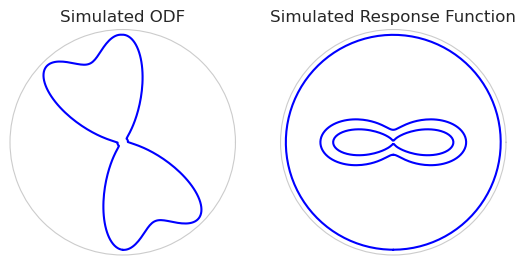

In [9]:
fig, axs = plt.subplots(1, 2, subplot_kw={'projection': 'polar'})

sh.plot_odf_on_axis(odf_sim, ax=axs[0])
axs[0].set_title('Simulated ODF')

sh.plot_wmr_on_axis(rf_sim, bvals=bvals, ax=axs[1])
axs[1].set_title('Simulated Response Function')
plt.show()

In [16]:
reps = 500

noise_free = np.repeat(dwi_sim, reps, axis=0)

dwi_noise_10 = add_noise(noise_free, grad, 10)
dwi_noise_20 = add_noise(noise_free, grad, 20)
dwi_noise_50 = add_noise(noise_free, grad, 50)

dwi = np.asarray([dwi_noise_10, dwi_noise_20, dwi_noise_50, noise_free]).reshape((4, reps, 1, -1))
mask = np.ones(dwi.shape[:-1], dtype=bool)

noise_10 = varia.rmse(dwi_noise_10, noise_free, np.ones(dwi_noise_10.shape[:-1], dtype=bool))
noise_20 = varia.rmse(dwi_noise_20, noise_free, np.ones(dwi_noise_20.shape[:-1], dtype=bool))
noise_50 = varia.rmse(dwi_noise_50, noise_free, np.ones(dwi_noise_50.shape[:-1], dtype=bool))
no_noise = np.zeros_like(noise_10)
noise = np.asarray([noise_10, noise_20, noise_50, no_noise])

In [17]:
varia.pretty_print_gradient_table(grad)

b-value   |   count   
----------------------
    0     |   2
 1000     |   128
 2000     |   128


In [19]:
odf_est_msmt_csd = get_msmt_csd_odf(dwi, rf_sim, grad).reshape((4, reps, 1, -1))
acc_msmt_csd = sh.angularCorrelation(odf_sim, odf_est_msmt_csd)
res_msmt_csd = varia.rmse(sh.calcdwi(sh.sphconv(rf_sim, odf_est_msmt_csd), grad), dwi, mask)

dwi2fod: [WARNING] existing output files will be overwritten
dwi2fod: [100%] preloading data for "/home/sleyse4/repos/lore_sd/src/tmp/voxels.mif"[0K
dwi2fod: [100%] performing MSMT CSD (3 shells, 1 tissue)[0K


# Hyperparameter Tuning: Regularisation parameter $\lambda$

In [23]:
log_test = np.logspace(-7, 0, 8)
full_acc_values = []
full_residuals = []
for reg in log_test:
    result = optimise.get_signal_decomposition(dwi, mask, grad, axial_diffusivities, radial_diffusivities, reg=reg, cores=cores)
    acc = sh.angularCorrelation(odf_sim, result['odf'])
    reconstructed_signal = sh.calcdwi(sh.sphconv(result['response'], result['odf']), grad)
    residual = varia.rmse(dwi, reconstructed_signal, mask)
    full_acc_values.append(acc)
    full_residuals.append(residual)

full_acc_values = np.squeeze(full_acc_values)
full_residuals = np.squeeze(full_residuals)

dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63262.915459609278
100%|███████████████████████████████████████| 2000/2000 [00:31<00:00, 62.60it/s]


Execution time: 00h 00m 42s


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63263.169356722407
100%|███████████████████████████████████████| 2000/2000 [00:33<00:00, 59.63it/s]


Execution time: 00h 00m 39s


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63262.987390897993
100%|███████████████████████████████████████| 2000/2000 [00:32<00:00, 61.07it/s]


Execution time: 00h 00m 42s


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63263.010615346611
100%|███████████████████████████████████████| 2000/2000 [00:40<00:00, 48.85it/s]


Execution time: 00h 00m 47s


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63263.001458046398
100%|███████████████████████████████████████| 2000/2000 [00:35<00:00, 56.98it/s]


Execution time: 00h 00m 41s


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63262.903849862465
100%|███████████████████████████████████████| 2000/2000 [00:27<00:00, 71.77it/s]


Execution time: 00h 00m 35s


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63263.113388670812
100%|███████████████████████████████████████| 2000/2000 [00:28<00:00, 68.98it/s]


Execution time: 00h 00m 38s


dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63262.994605341592
100%|███████████████████████████████████████| 2000/2000 [01:12<00:00, 27.46it/s]


Execution time: 00h 01m 19s


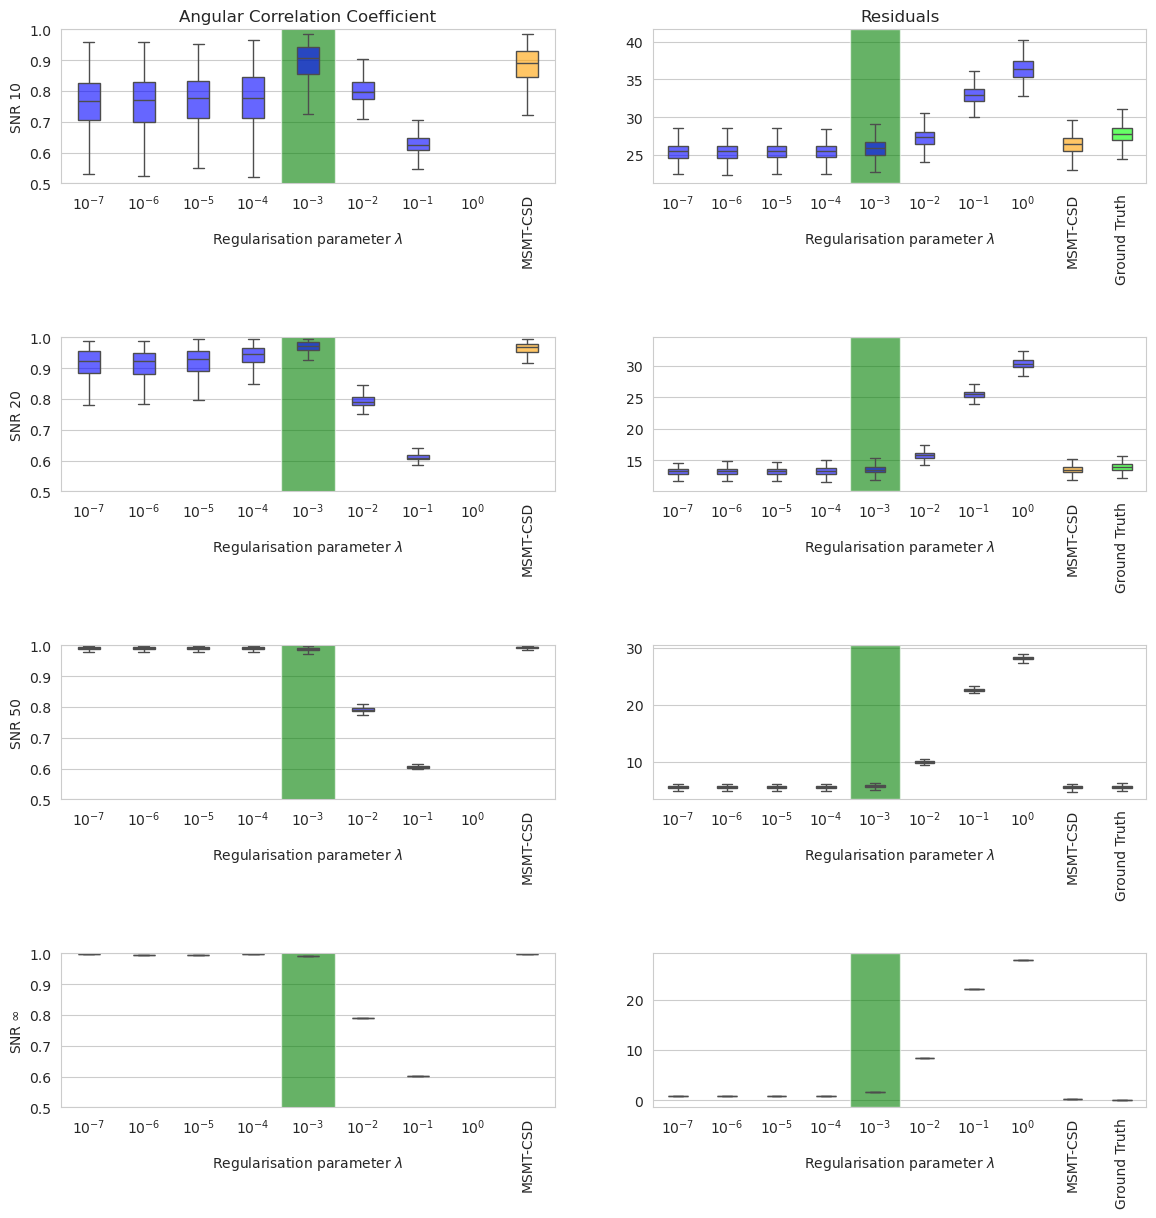

In [40]:
fig = plt.figure(figsize=(14,14))

gs = fig.add_gridspec(4, 2, wspace=.2, hspace=1)

for i, snr in enumerate(['10', '20', '50', r'$\infty$']):

    acc_ax = fig.add_subplot(gs[i, 0])

    acc_rect = plt.Rectangle((3.5, 0), 1, 2, facecolor='green', alpha=.6)
    acc_ax.add_patch(acc_rect)

    acc_to_plot = np.concatenate((full_acc_values[:,i].T, acc_msmt_csd[i]), axis=-1)

    acc_palette = [(0, 0, 1, .6) for _ in range(acc_to_plot.shape[-1]-1)] + [(1, 160/255, 0, .6)]

    acc_boxplot = sns.boxplot(acc_to_plot, fliersize=0, ax=acc_ax, palette=acc_palette, width=.4, saturation=1)

    acc_ax.set_xticks(range(len(log_test)+1), [f'$10^{{{np.log10(e):.0f}}}$' for e in log_test] + ['MSMT-CSD'])
    acc_ax.get_xticklabels()[-1].set_rotation(90)
    acc_ax.set_ylabel(f'SNR {snr}')
    acc_ax.set_xlabel(r'Regularisation parameter $\lambda$')
    acc_ax.xaxis.set_label_coords(.5, -.3)

    if i == 0:
        acc_ax.set_title(f'Angular Correlation Coefficient')
    acc_ax.set_ylim(.5, 1)

    res_ax = fig.add_subplot(gs[i, 1])

    res_to_plot = np.concatenate((full_residuals[:,i].T, res_msmt_csd[i], noise[i,None].T), axis=-1)

    res_palette = [(0, 0, 1, .6) for _ in range(res_to_plot.shape[-1]-2)] + [(1, 160/255, 0, .6), (0, 1, 0, .6)]

    res_boxplot = sns.boxplot(res_to_plot, fliersize=0, ax=res_ax, palette=res_palette, width=.4, saturation=1)

    res_ylim = res_ax.get_ylim()

    res_ax.set_xticks(range(len(log_test)+2), [f'$10^{{{np.log10(e):.0f}}}$' for e in log_test] + ['MSMT-CSD', 'Ground Truth'])
    res_ax.get_xticklabels()[-2].set_rotation(90)
    res_ax.get_xticklabels()[-1].set_rotation(90)
    res_ax.set_xlabel(r'Regularisation parameter $\lambda$')
    res_ax.xaxis.set_label_coords(.5, -.3)

    res_rect = plt.Rectangle((3.5, res_ylim[0]), 1, res_ylim[1] - res_ylim[0], facecolor='green', alpha=.6)
    res_ax.add_patch(res_rect)

    if i == 0:
        res_ax.set_title(f'Residuals')

# Hyperparameter Tuning: Grid Size

In [41]:
ax_test = [3,5,7,10,15,20]
rad_test = [3,5,7,10,15,20]

grid_acc_values = []
grid_residuals = []

for num in ax_test:
    ad_range = np.linspace(0, 4e-3, num)
    rd_range = np.linspace(0, 4e-3, num)
    result = optimise.get_signal_decomposition(dwi, mask, grad, ad_range, rd_range, reg=1e-3, cores=cores)
    acc = sh.angularCorrelation(odf_sim, result['odf'])
    residual = result['residual']
    grid_acc_values.append(acc)
    grid_residuals.append(residual)

grid_acc_values = np.asarray(grid_acc_values)
grid_residuals = np.asarray(grid_residuals)

dirgen: [done] Optimising directions up to power 1 (10 restarts)[0K
dirgen: final energy = 63263.086613447922
100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 109.94it/s]


Execution time: 00h 00m 31s


KeyError: 'residual'

In [ ]:
fig = plt.figure(figsize=(14,14))

gs = fig.add_gridspec(4, 2, wspace=.2, hspace=1)

for i, snr in enumerate(['10', '20', '50', r'$\infty$']):

    acc_ax = fig.add_subplot(gs[i, 0])

    acc_to_plot = np.concatenate((grid_acc_values[:,i].T, acc_msmt_csd[i,None].T), axis=-1)

    acc_palette = [(0, 0, 1, .6) for _ in range(acc_to_plot.shape[-1]-1)] + [(1, 160/255, 0, .6)]

    sns.boxplot(acc_to_plot, fliersize=0, ax=acc_ax, palette=acc_palette, width=.4, saturation=1)

    acc_ax.set_xticks(range(len(ax_test)+1), ax_test + ['MSMT-CSD'])
    acc_ax.get_xticklabels()[-1].set_rotation(90)
    acc_ax.set_ylabel(f'SNR {snr}')
    acc_ax.set_xlabel(r'Regularisation parameter $\lambda$')
    acc_ax.xaxis.set_label_coords(.5, -.3)

    acc_ax.set_ylabel(f'SNR {snr}')
    acc_ax.set_xlabel('Grid Size')

    if i == 0:
        acc_ax.set_title(f'Angular Correlation Coefficient')
    acc_ax.set_ylim(.5, 1)

    acc_rect = plt.Rectangle((2.5, 0), 1, 2, facecolor='green', alpha=.6)
    acc_ax.add_patch(acc_rect)

    res_ax = fig.add_subplot(gs[i, 1])

    res_to_plot = np.concatenate((grid_residuals[:,i].T, res_msmt_csd[i,None].T, noise[i, None].T), axis=-1)
    res_palette = [(0, 0, 1, .6) for _ in range(res_to_plot.shape[-1]-2)] + [(1, 160/255, 0, .6), (0, 1, 0, .6)]

    sns.boxplot(res_to_plot, fliersize=0, ax=res_ax, palette=res_palette, width=.4, saturation=1)

    res_ax.set_xticks(range(len(ax_test)+2), ax_test + ['MSMT-CSD', 'Ground Truth'])
    res_ax.get_xticklabels()[-2].set_rotation(90)
    res_ax.get_xticklabels()[-1].set_rotation(90)
    res_ax.set_xlabel(r'Regularisation parameter $\lambda$')
    res_ax.xaxis.set_label_coords(.5, -.3)

    res_ax.set_xlabel('Grid Size')

    res_ylim = res_ax.get_ylim()

    res_rect = plt.Rectangle((2.5, res_ylim[0]), 1, res_ylim[1] - res_ylim[0], facecolor='green', alpha=.6)
    res_ax.add_patch(res_rect)

    if i == 0:
        res_ax.set_title(f'Estimated Noise')